In [1]:
#| echo: false
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime

import igraph as ig
from scipy import stats
from scipy.stats import t
import plotly.graph_objs as go
import seaborn as sns
from random import sample
import plotly.express as px

import sys
sys.path.append('../src')
from utils import autoparse_year

import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

In [2]:
#| echo: false
import warnings
warnings.filterwarnings("ignore")

In [3]:
#| echo: false
df_edges = pd.read_pickle('../data/generated/graph/actor_graph_full.grouped.pkl')
df_actors = pd.read_pickle('../data/generated/preprocessed/characters.pkl')

In [4]:
#| echo: false
#| output: false
x=df_edges.rename(columns={"actor2_fbid": "actor1_fbid","actor1_fbid": "actor2_fbid"})
df_edges= pd.concat([df_edges, x])
df_edges

,actor1_fbid,actor2_fbid,movie_count
503637,/m/02cvp8,/m/02t0n9,219
655465,/m/02t0n9,/m/045g4l,119
503747,/m/02cvp8,/m/045g4l,119
906950,/m/03mv0b,/m/0lh0c,101
503668,/m/02cvp8,/m/030dx5,82
...,...,...,...
717939,/m/09rxk8z,/m/02z28y7,1
717938,/m/09rvxt5,/m/02z28y7,1
717937,/m/09q3gc,/m/02z28y7,1
717936,/m/09jlgq,/m/02z28y7,1


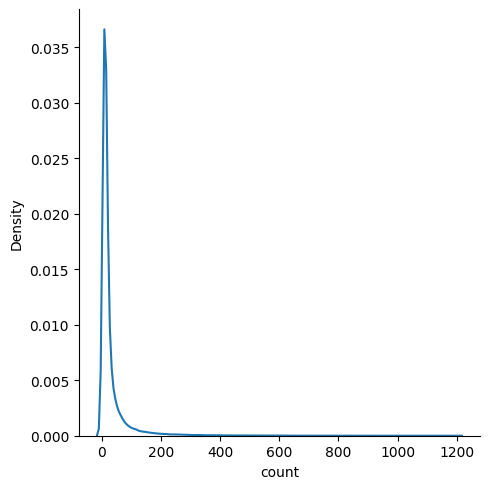

In [5]:
#| echo: false
#| output: false
test =df_edges.groupby('actor1_fbid')['actor2_fbid'].agg(['count']).sort_values(by='count')
test2 = test[test['count'] > 3]
sns.displot(test, x="count", kind="kde")

# Homophily and attributes analysis

As we introduced in the overview, one purpose of this project was to focus on the analysis of how connected actors could be influenced to play in the same movie based on their distinguished attributes. In other words, does "similar" actors are more likely connected into the same movie. We need therefore a definition of the similarity. According to several papers, one main tool to assess the similarity is called the homophily. It is the tendency for people to be attracted to those who seems similar to themselves. 

Knowing that we are working on a dataset of actor who are linked between each other through movies, we decided to consider only actors with a minimum degree of fifteen (which is quiet representative to movies in general as the movie story is based on interaction between a quiet large number of characters). Moreover, we also took our decision because low degree vertices shall add some unmeaningful values, particularly for categorical attribute (which can even become binary for very low link degree).

In [6]:
#| echo: false
df_edges= df_edges[df_edges.apply(lambda x: True if test.loc[x.actor1_fbid]['count']> 15 else False, axis =1)]

In [7]:
#| echo: false
#| output: false
df_actors['year_of_birth'] = df_actors.actor_birth.apply(autoparse_year).astype('Int64')
df_actors=df_actors.rename(columns={"fb_actor_id": "actor1_fbid"})
df_actors

,wiki_id,fb_movie_id,release,character_name,actor_age,fb_char_id,actor1_fbid,release_year,actor_birth_year,actor_name,actor_birth,ethnicity,actor_height,actor_gender,actor_nationality,pageviews,year_of_birth
0,975900,/m/03vyhn,2001-08-24,Akooshay,42.0,/m/0bgchxw,/m/03wcfv7,2001,1958,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,NaN,1958
1,24767455,/m/0809s7n,2009-10-16,Captain Diaz,51.0,/m/08d9z0b,/m/03wcfv7,2009,1958,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,NaN,1958
2,5337169,/m/0dg7mt,2001,NaN,42.0,/m/04htxdc,/m/03wcfv7,2001,1958,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,NaN,1958
3,1330220,/m/04t8wq,1990-06-22,NaN,31.0,/m/0cg7kl2,/m/03wcfv7,1990,1958,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,NaN,1958
4,14686017,/m/03gt21w,1990-01-12,NaN,31.0,/m/09j0r8t,/m/03wcfv7,1990,1958,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,NaN,1958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450658,913762,/m/03pcrp,1992-05-21,Additional Voices,38.0,/m/0kr405f,/m/0gn4bz,1992,1954,Sonny Byrkett,1954,NaN,NaN,M,NaN,NaN,1954
450659,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,38.0,/m/0kr407w,/m/0gn4bz,1992,1954,Sonny Byrkett,1954,NaN,NaN,M,NaN,NaN,1954
450660,913762,/m/03pcrp,1992-05-21,Silvie Gena,34.0,/m/0kr40b9,/m/0gn4nd,1992,1958,Susan Byrkett,1958,NaN,NaN,F,NaN,NaN,1958
450661,913762,/m/03pcrp,1992-05-21,Exegran,NaN,/m/0kr407c,/m/0kr407h,1992,<NA>,Hal Cleaveland,NaN,NaN,NaN,M,NaN,NaN,<NA>


In [8]:
#| echo: false
#| output: false
df_actors_reduced= df_actors.drop_duplicates(subset= 'actor1_fbid')
df_actors_reduced= df_actors_reduced.drop(['wiki_id','fb_movie_id','release','character_name','fb_char_id','actor_birth'], axis=1)
group_by_degree = df_edges.groupby('actor1_fbid')['actor2_fbid'].agg(['count'])
df_degree = pd.DataFrame({'actor_degree': list(group_by_degree['count']), 'actor1_fbid': group_by_degree.index})
df_actors_reduced= df_actors_reduced.merge(df_degree, on= 'actor1_fbid')
df_actors_reduced= pd.merge(df_actors_reduced, (df_actors.groupby('actor1_fbid').apply(lambda x: pd.Series({
        'number_of_movies': x['wiki_id'].count()
    }))),on='actor1_fbid')
df_edges_merged= df_edges.merge(df_actors_reduced,
                                 on='actor1_fbid').merge(df_actors_reduced.rename(columns={"actor1_fbid": "actor2_fbid"}), on='actor2_fbid')
df_edges_merged

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,release_year_x,actor_birth_year_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,...,actor_birth_year_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,pageviews_y,year_of_birth_y,actor_degree_y,number_of_movies_y
0,/m/02cvp8,/m/02t0n9,219,NaN,1958,1897,Moe Howard,NaN,1.620,M,...,1902,Larry Fine,NaN,1.6256,M,United States of America,NaN,1902,357,219
1,/m/026xmsr,/m/02t0n9,72,NaN,1955,1895,Vernon Dent,NaN,NaN,M,...,1902,Larry Fine,NaN,1.6256,M,United States of America,NaN,1902,357,219
2,/m/02z023s,/m/02t0n9,40,NaN,1936,1894,Bud Jamison,NaN,NaN,M,...,1902,Larry Fine,NaN,1.6256,M,United States of America,NaN,1902,357,219
3,/m/030dx5,/m/02t0n9,82,NaN,1955,1895,Samuel Howard,NaN,1.651,M,...,1902,Larry Fine,NaN,1.6256,M,United States of America,NaN,1902,357,219
4,/m/03gsgd9,/m/02t0n9,23,NaN,<NA>,1903,Eddie Laughton,NaN,NaN,M,...,1902,Larry Fine,NaN,1.6256,M,United States of America,NaN,1902,357,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036589,/m/0crc1n7,/m/02y_r9n,3,28.0,1957,1929,S. Shamsuddin,NaN,NaN,M,...,1925,Aziz Sattar,NaN,NaN,M,Malaysia,NaN,1925,17,7
3036590,/m/02f27,/m/0gcb2b4,1,61.0,2007,1945,Dirk Benedict,NaN,1.800,M,...,<NA>,Eike Becker,NaN,NaN,M,NaN,NaN,<NA>,19,2
3036591,/m/03qp512,/m/02pyhqk,1,27.0,1972,1945,Peter Lee Lawrence,NaN,NaN,M,...,1942,Steve Sipek,NaN,NaN,M,Canada,NaN,1942,16,2
3036592,/m/03cx_n5,/m/0gc6ycx,1,NaN,1987,<NA>,Joel Hoffman,NaN,NaN,M,...,<NA>,Courtney Lercara,NaN,NaN,F,NaN,NaN,<NA>,18,2


In [9]:
#| echo: false
df_edges_gender=df_edges_merged.dropna(subset=['actor_gender_x'])
df_edges_gender=df_edges_gender.dropna(subset=['actor_gender_y'])

df_edges_nat=df_edges_merged.dropna(subset=['actor_nationality_x'])
df_edges_nat=df_edges_nat.dropna(subset=['actor_nationality_y'])


df_edges_birth=df_edges_merged.dropna(subset=['year_of_birth_x'])
df_edges_birth=df_edges_birth.dropna(subset=['year_of_birth_y'])
df_edges_birth= df_edges_birth[df_edges_birth['year_of_birth_x'] < 2022]
df_edges_birth= df_edges_birth[df_edges_birth['year_of_birth_y'] < 2022]
df_edges_birth=df_edges_birth[df_edges_birth['year_of_birth_x']>1800]
df_edges_birth=df_edges_birth[df_edges_birth['year_of_birth_y']>1800]
std_yob = df_edges_birth.apply(lambda x : abs(x.year_of_birth_x-x.year_of_birth_y),axis=1).std()

df_edges_height=df_edges_merged.dropna(subset=['actor_height_x'])
df_edges_height= df_edges_height.dropna(subset=['actor_height_y'])
df_edges_height=df_edges_height[df_edges_height['actor_height_x']<3]
df_edges_height=df_edges_height[df_edges_height['actor_height_y']<3]
std_height = df_edges_height.drop_duplicates(subset= 'actor1_fbid').apply(lambda x : abs(x.actor_height_x),axis=1).std()

df_edges_nbr_movies=df_edges_merged.dropna(subset=['number_of_movies_x'])
df_edges_nbr_movies= df_edges_nbr_movies.dropna(subset=['number_of_movies_y'])
std_nbr_movies = df_edges_nbr_movies.drop_duplicates(subset= 'actor1_fbid').apply(lambda x : abs(x.number_of_movies_x),axis=1).std()

First of all, as we will based our study on the attributes, we need to begin our analysis by quantify each attributes among the different actors of the dataset.

- For the actor nationality, we have the following interactive plot. We observe a majority (around 45%) of american actors, followed by some country like Canada, India, Great britain, ... We need to keep this distribution in mind for the rest of our study, especially for the comparison part.

In [10]:
#| echo: false
visualization_nat= df_edges_nat.drop_duplicates(subset= "actor1_fbid").groupby('actor_nationality_x')['actor2_fbid'].agg(['count'])
visualization_nat['country']= visualization_nat.index
visualization_nat= visualization_nat.reset_index(drop= True)
choropleth_map = go.Figure(
    data = {
        'type':'choropleth',
        'locations':visualization_nat['country'],
        'locationmode':'country names',
        'colorscale':'Portland',
        'z':visualization_nat['count'],
        'colorbar':{'title':'World Population in 2020'},
        'marker': {
            'line': {
                'color':'rgb(255,255,255)',
                'width':2
            }
        }
    },     
)

choropleth_map.update_layout(
    geo=go.layout.Geo(
        showframe=True,
        showcoastlines=True,
        projection_type='natural earth2',
        showcountries= True
    ),
    hovermode='closest',
    width=900,
    height=600,
    title='World Map with number of Actors per Country'
)

- Furthermore, we have the four other parameters with their associated distribution according to the dataset :

In [11]:
#| echo: false
gender_distribution= df_edges_gender.drop_duplicates(subset= 'actor1_fbid').groupby('actor_gender_x')['actor1_fbid'].agg(['count'])
gender_distribution['gender']= gender_distribution.index

fig = px.pie(gender_distribution, values='count', names='gender', title='Gender Distribution in the Dataset',
                 width=500, height = 400)
fig.show()

[(0.8, 2.3)]

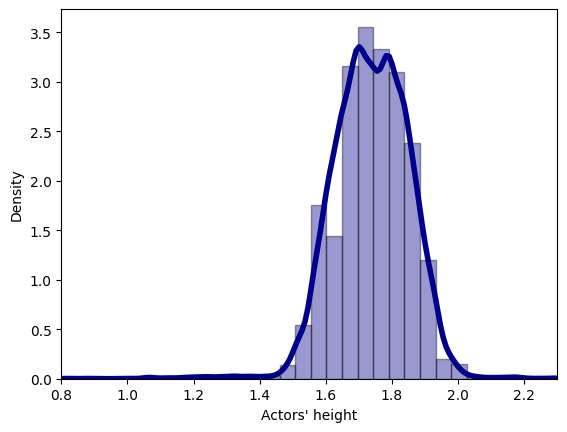

In [12]:
#| echo: false
#| output: false
height_distribution= df_edges_height.drop_duplicates(subset= 'actor1_fbid')['actor_height_x']
g1= sns.distplot(height_distribution, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
g1.set_xlabel('Actors\' height')
g1.set(xlim=(0.8, 2.3))

[(1, 100)]

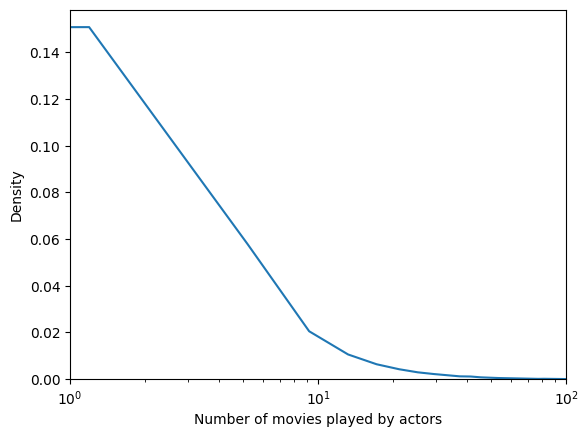

In [13]:
#| echo: false
#| output: false
nbr_movies_distribution= df_edges_nbr_movies.drop_duplicates(subset= 'actor1_fbid')['number_of_movies_x']
g2= sns.kdeplot(data=nbr_movies_distribution)
g2.set_xscale('log')
g2.set_xlabel('Number of movies played by actors')
g2.set(xlim=(1, 100))

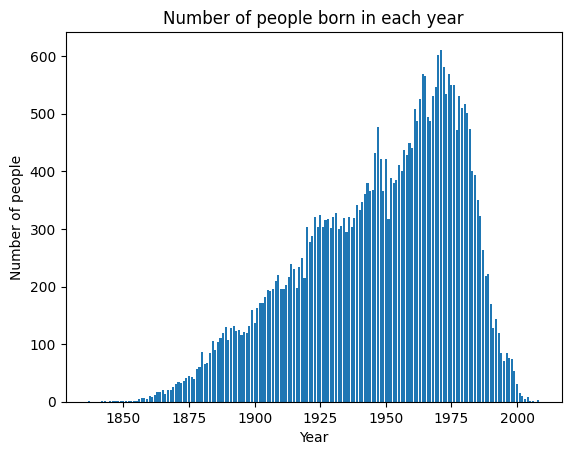

In [14]:
#| echo: false
df_edges_birth_unique= df_edges_birth.drop_duplicates(subset= 'actor1_fbid')
year_counts = {}
for year in df_edges_birth_unique.year_of_birth_x:
    if year not in year_counts:
        year_counts[year] = 1
    else:
        year_counts[year] += 1

# Extract the years and counts as separate lists
years = list(year_counts.keys())
counts = list(year_counts.values())

# Plot the data using matplotlib
plt.bar(years, counts)
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Number of people born in each year')
plt.show()

[(1, 100)]

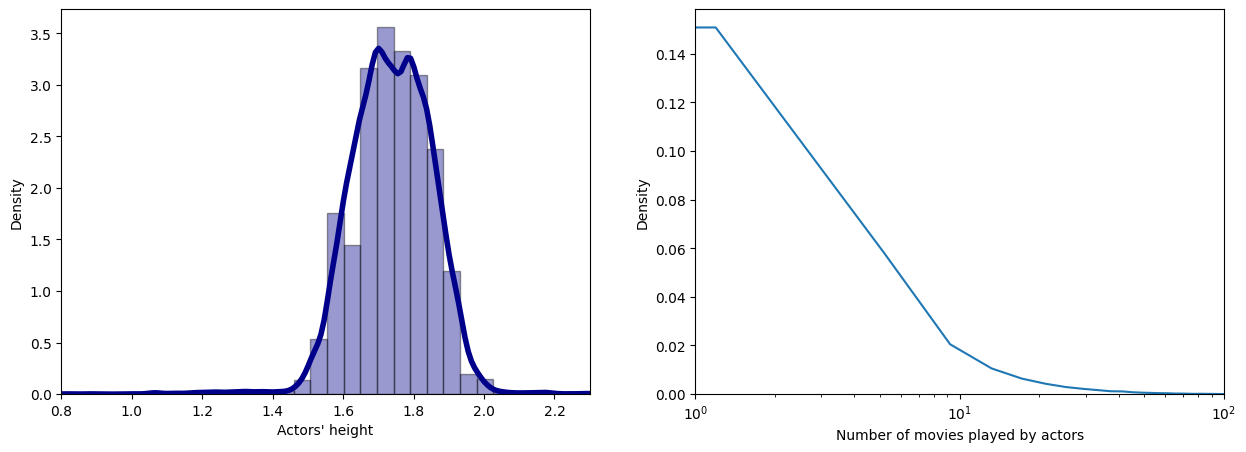

In [15]:
#| echo: false
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

g1= sns.distplot(ax=axes[0], x= height_distribution, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
g1.set_xlabel('Actors\' height')
g1.set(xlim=(0.8, 2.3))

g2= sns.kdeplot(ax=axes[1], data=nbr_movies_distribution)
g2.set_xscale('log')
g2.set_xlabel('Number of movies played by actors')
g2.set(xlim=(1, 100))

Some of these distributions are likely to be gaussian (height) or even a power low distribution for the number of movies played. We can mention that the gender attribute is unbalanced in our dataset and need to be also taken with caution for further interpretations.

We will now pay attention to quantify the homophily score of each actor :
- For categorical attribute, it can be describe as follow : $$Homophily_{i} = \frac{\sum \limits _j \delta_{ij}}{k_i} $$  with $ \delta_{ij} $ = 1 if same attribute, else -1 and $ k_i $ the degree of the node i


- For scalar attribute, we can create a linear equation, meaning that the further the values are apart, the lower the value will be. We illustrated this defintion through the following plot :

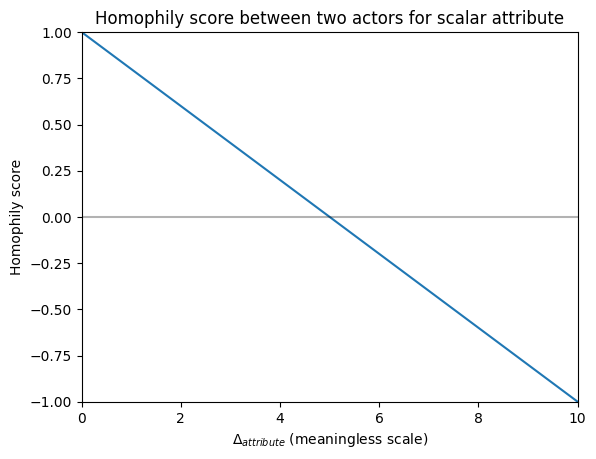

In [16]:
#| echo: false
max_scalar_difference = 10

# Generate a list of positive values for delta x
delta_x_values = list(range(0, max_scalar_difference+1))

# Calculate the corresponding values of y
y_values = [(1 - (2 * (delta_x) / max_scalar_difference)) for delta_x in delta_x_values]

# Plot the values
plt.plot(delta_x_values, y_values)

# Add labels and show the plot
#plt.xlabel(r'$\Delta scalar attributes (meaningless scale)')
plt.xlabel(''r'$\Delta_{attribute}$ (meaningless scale)')
plt.xlim(0,10)
plt.axhline(0, color="black", alpha=0.3)
plt.ylim(-1,1)
plt.ylabel('Homophily score')
plt.title('Homophily score between two actors for scalar attribute')
plt.show()

The value for which we consider the homophily score to -1 depends on the standard deviation of the distribution (we target to aim the 95% threshold). $$ \Delta_{max} = 2 \times \sigma $$

- We then compute these homophily scores for each actors in order to vizualise the distribution. We end up with the following distributions according to the different attributes. The four first distributions are the categorical attributes especially with the distribution if the take only the homophily score of men actors (gender men) compared to the case where we take only the homophily score of women actress (gender women). The three next distributions are dedicated to the scalar attributes :

In [17]:
#| echo: false
#| output: false
homophily = {}
df_edges_birth['homophily_age'] = df_edges_birth.apply(lambda x: (1- 2*abs(x.year_of_birth_x-x.year_of_birth_y)/(2*std_yob)) if abs(x.year_of_birth_x-x.year_of_birth_y)/(2*std_yob) < 1 else -1, axis= 1)
age_homophily = df_edges_birth.groupby('actor1_fbid')['homophily_age'].agg(['mean'])
print('mean =',age_homophily.mean(), 'and std =', age_homophily.std())
homophily['age']= {
		'mean': float(age_homophily.mean()),
		'std': float(age_homophily.std())
	}

mean = mean   -0.064151
dtype: float64 and std = mean    0.285441
dtype: float64


In [18]:
#| echo: false
#| output: false
df_edges_height['homophily_height'] = df_edges_height.apply(lambda x: (1- 2*abs(x.actor_height_x-x.actor_height_y)/(2*std_height)) if abs(x.actor_height_x-x.actor_height_y)/(2*std_height) < 1 else -1 , axis= 1)
height_homophily = df_edges_height.groupby('actor1_fbid')['homophily_height'].agg(['mean'])
print('mean =',height_homophily.mean(), 'and std =', height_homophily.std())
homophily['height']= {
		'mean': float(height_homophily.mean()),
		'std': float(height_homophily.std())
	}

mean = mean    0.037004
dtype: float64 and std = mean    0.297645
dtype: float64


In [19]:
#| echo: false
#| output: false
df_edges_gender['same_gender'] = df_edges_gender.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
gender_homophily = df_edges_gender.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print('mean =',gender_homophily.mean(), 'and std =', gender_homophily.std())
homophily['gender']= {
		'mean': float(gender_homophily.mean()),
		'std': float(gender_homophily.std())
	}

mean = mean    0.120826
dtype: float64 and std = mean    0.405169
dtype: float64


> check value for male actor and female actress indenpendantly

In [20]:
#| echo: false
#| output: false
edges_gender_m = df_edges_merged[df_edges_merged['actor_gender_x'] == 'M']
edges_gender_m= edges_gender_m.dropna(subset=['actor_gender_y'])
edges_gender_m['same_gender'] = edges_gender_m.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
gender_homophily_m = edges_gender_m.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print(gender_homophily_m.mean(), gender_homophily_m.std())
homophily['gender_m']= {
		'mean': float(gender_homophily_m.mean()),
		'std': float(gender_homophily_m.std())
	}

mean    0.365263
dtype: float64 mean    0.238025
dtype: float64


In [21]:
#| echo: false
#| output: false
edges_gender_f = df_edges_merged[df_edges_merged['actor_gender_x'] == 'F']
edges_gender_f= edges_gender_f.dropna(subset=['actor_gender_y'])
edges_gender_f['same_gender'] = edges_gender_f.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
gender_homophily_f = edges_gender_f.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print('mean =',gender_homophily_f.mean(), 'and std =', gender_homophily_f.std())
homophily['gender_f']= {
		'mean': float(gender_homophily_f.mean()),
		'std': float(gender_homophily_f.std())
	}

mean = mean   -0.308927
dtype: float64 and std = mean    0.251859
dtype: float64


In [22]:
#| echo: false
#| output: false
df_edges_nat['same_country'] = df_edges_nat.apply(lambda x: 1 if (x.actor_nationality_x == x.actor_nationality_y) else (-1), axis= 1)
country_homophily = df_edges_nat.groupby('actor1_fbid')['same_country'].agg(['mean'])
print('mean =',country_homophily.mean(), 'and std =', country_homophily.std())
homophily['country']= {
		'mean': float(country_homophily.mean()),
		'std': float(country_homophily.std())
	}

mean = mean    0.441165
dtype: float64 and std = mean    0.579339
dtype: float64


In [23]:
#| echo: false
#| output: false
df_edges_nbr_movies['same_nbr_movies'] = df_edges_nbr_movies.apply(lambda x: (1- 2*abs(x.number_of_movies_x -x.number_of_movies_y)/(2*std_nbr_movies)) if abs(x.number_of_movies_x -x.number_of_movies_y)/(2*std_nbr_movies) < 1 else -1, axis= 1)
nbr_movies_homophily = df_edges_nbr_movies.groupby('actor1_fbid')['same_nbr_movies'].agg(['mean'])
print('mean =',nbr_movies_homophily.mean(), 'and std =', nbr_movies_homophily.std())
homophily['nbr_of_movies']= {
		'mean': float(nbr_movies_homophily.mean()),
		'std': float(nbr_movies_homophily.std())
	}

mean = mean    0.25611
dtype: float64 and std = mean    0.418973
dtype: float64


In [24]:
#| echo: false
#| output: false
homophily

{'age': {'mean': -0.06415065882585416, 'std': 0.28544056872347395},
 'height': {'mean': 0.037004392607091256, 'std': 0.29764467680409756},
 'gender': {'mean': 0.12082618928542174, 'std': 0.405168590697329},
 'gender_m': {'mean': 0.3652634255709688, 'std': 0.23802527529538983},
 'gender_f': {'mean': -0.308926727466187, 'std': 0.25185901038447406},
 'country': {'mean': 0.4411654013013045, 'std': 0.5793386508750955},
 'nbr_of_movies': {'mean': 0.2561099963111562, 'std': 0.4189729616238701}}

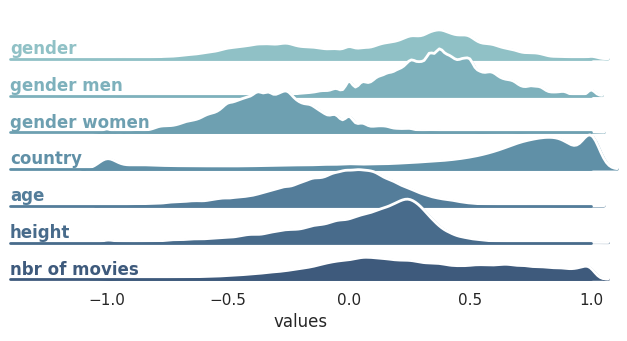

In [25]:
#| echo: false

df_visu = pd.DataFrame({'values':gender_homophily['mean']})
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_m['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_f['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':country_homophily['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':age_homophily['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':height_homophily['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':nbr_movies_homophily['mean']})])
range_idx = [len(gender_homophily),len(gender_homophily_m),len(gender_homophily_f),len(country_homophily),len(age_homophily),len(height_homophily),len(nbr_movies_homophily)]
name = ['gender','gender men','gender women','country','age','height','nbr of movies']
idx= []
for i, name in zip(range_idx, name):
    for j in range(i):
        idx.append(name)
df_visu['name']= idx
df_visu= df_visu.reset_index(drop=True)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_visu, row="name", hue="name", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "values")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(-1.4, 1))



In [26]:
#| echo: false
#| output: false
df_visu = pd.DataFrame({'values':gender_homophily['mean']})
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_m['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_f['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':country_homophily['mean']})])
df_visu

,values
actor1_fbid,
/m/010p3,0.348315
/m/010q36,0.600000
/m/010xjr,0.462687
/m/0112yl,0.475113
/m/011_24,0.363636
...,...
/m/0z05l,-0.424000
/m/0z4s,0.005666
/m/0z9q0,-1.000000


In [27]:
#| echo: false
#| output: false
df_visu2 = pd.DataFrame({'values':age_homophily['mean']})
df_visu2= pd.concat([df_visu2, pd.DataFrame({'values':height_homophily['mean']})])
df_visu2= pd.concat([df_visu2, pd.DataFrame({'values':nbr_movies_homophily['mean']})])
df_visu2

,values
actor1_fbid,
/m/010p3,0.277170
/m/010q36,-0.635011
/m/010xjr,-0.221980
/m/0112yl,-0.030323
/m/011_24,0.362889
...,...
/m/0z05l,-0.498495
/m/0z4s,-0.955392
/m/0z9q0,0.411110


In [28]:
#| echo: false
#| output: false
range_idx = [len(gender_homophily),len(gender_homophily_m),len(gender_homophily_f),len(country_homophily)]
name = ['gender','gender_m','gender_f','country']
idx= []
for i, name in zip(range_idx, name):
    for j in range(i):
        idx.append(name)
df_visu['name']= idx
df_visu= df_visu.reset_index(drop=True)
range_idx = [len(age_homophily),len(height_homophily),len(nbr_movies_homophily)]
name = ['age','height','nbr_movies_played']
idx= []
for i, name in zip(range_idx, name):
    for j in range(i):
        idx.append(name)
df_visu2['name']= idx
df_visu2= df_visu2.reset_index(drop=True)
df_visu,df_visu2

(          values     name
 0       0.348315   gender
 1       0.600000   gender
 2       0.462687   gender
 3       0.475113   gender
 4       0.363636   gender
 ...          ...      ...
 137078 -0.424000  country
 137079  0.005666  country
 137080 -1.000000  country
 137081  0.931034  country
 137082  0.506849  country
 
 [137083 rows x 2 columns],
           values               name
 0       0.277170                age
 1      -0.635011                age
 2      -0.221980                age
 3      -0.030323                age
 4       0.362889                age
 ...          ...                ...
 104310 -0.498495  nbr_movies_played
 104311 -0.955392  nbr_movies_played
 104312  0.411110  nbr_movies_played
 104313  0.019013  nbr_movies_played
 104314 -0.788681  nbr_movies_played
 
 [104315 rows x 2 columns])

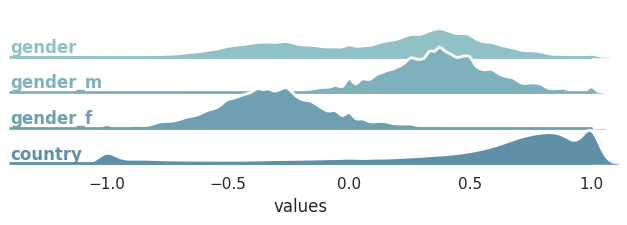

In [29]:
#| echo: false
#| output: false
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_visu, row="name", hue="name", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "values")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(-1.4, 1))



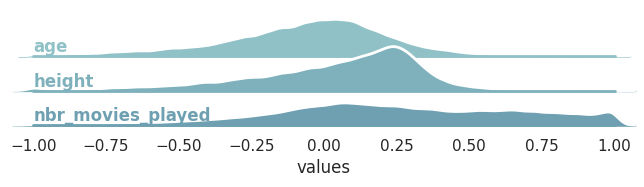

In [30]:
#| echo: false
#| output: false
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_visu2, row="name", hue="name", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "values")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(-1, 1))



## Comparison with "mean actor" of the dataset

In [31]:
#| echo: false
#| output: false
df_gender_reduced = df_edges_gender.drop_duplicates(subset= 'actor1_fbid')
nbr_of_men = len(df_gender_reduced[df_gender_reduced['actor_gender_x'] == 'M'])
nbr_of_women = len(df_gender_reduced) - nbr_of_men
hypothetical_gender_homophily_score = (nbr_of_men*((nbr_of_men-1)+ (-1)*nbr_of_women))/(len(df_gender_reduced)-1) + (nbr_of_women*((nbr_of_women-1)+ (-1)*nbr_of_men))/(len(df_gender_reduced)-1)
hypothetical_gender_homophily= hypothetical_gender_homophily_score/len(df_gender_reduced)
hypothetical_gender_homophily


0.07553615796911524

In [32]:
#| echo: false
#| output: false
df_edges_nat_reduced = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')
xy = df_edges_nat_reduced.groupby('actor_nationality_x')['actor1_fbid'].agg(['count'])
total_actor= xy.sum()
homophily_score=0
for i in xy.iloc:
    homophily_score+= (int(i)*(int(i)-1)+(-1)*(total_actor-int(i)))/(total_actor-1)
hypo_homophily_country = homophily_score/total_actor
hypo_homophily_country

count    0.213315
dtype: float64

In [33]:
#| echo: false
#| output: false
df_actor_with_nat = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')[['actor1_fbid','actor_nationality_x']]
df_nat = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')
nbr_per_country = df_nat.groupby('actor_nationality_x')['actor1_fbid'].agg(['count'])
probabilties = pd.DataFrame({'country': list(nbr_per_country.index),'probability': list(nbr_per_country['count'].apply(lambda x: x/nbr_per_country.sum())['count'])})
probabilties


,country,probability
0,Albania,0.000085
1,Algeria,0.000141
2,Argentina,0.006394
3,Armenia,0.000028
4,Australia,0.019915
...,...,...
142,Weimar Republic,0.000141
143,West Bengal,0.000028
144,West Germany,0.000056
145,Yugoslavia,0.000085


In [34]:
#| echo: false
#| output: false
l =[]
for i in df_actor_with_nat.actor_nationality_x:
    l.append(float(probabilties[probabilties['country']== i].probability -(1-probabilties[probabilties['country']== i].probability)))
l
df_actor_with_nat['homophily_nat_mean_actor']= l

In [35]:
#| echo: false
#| output: false
df_visu_compare= pd.DataFrame({"homophily score nationalities":country_homophily['mean']})
df_visu_compare= pd.concat([df_visu_compare, pd.DataFrame({"homophily score nationalities":df_actor_with_nat['homophily_nat_mean_actor']})])
range_idx = [len(country_homophily),len(df_actor_with_nat)]
names = ['true edges','edges with mean actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare['subset']= idx
df_visu_compare= df_visu_compare.reset_index(drop=True)
df_visu_compare

,homophily score nationalities,subset
0,0.761905,true edges
1,0.600000,true edges
2,-0.923077,true edges
3,0.065421,true edges
4,0.593103,true edges
...,...,...
70997,-0.997747,edges with mean actor
70998,-0.997747,edges with mean actor
70999,-0.990930,edges with mean actor
71000,-0.998592,edges with mean actor


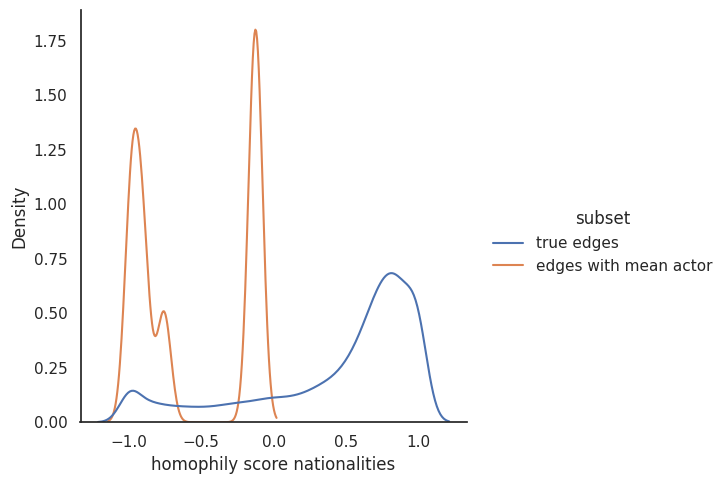

In [36]:
#| echo: false
sns.displot(data=df_visu_compare, x="homophily score nationalities", hue="subset", kind="kde")

In [37]:
#| echo: false
df_actor_with_gender = df_edges_gender.drop_duplicates(subset= 'actor1_fbid')[['actor1_fbid','actor_gender_x']]
nbr_per_gender = df_edges_gender.drop_duplicates(subset= 'actor1_fbid').groupby('actor_gender_x')['actor1_fbid'].agg(['count'])
probabilties = pd.DataFrame({'country': list(nbr_per_gender.index),'probability': list(nbr_per_gender['count'].apply(lambda x: x/nbr_per_gender.sum())['count'])})
l =[]
for i in df_actor_with_gender.actor_gender_x:
    l.append(float(probabilties[probabilties['country']== i].probability -(1-probabilties[probabilties['country']== i].probability)))
l
df_actor_with_gender['homophily_gender_mean_actor']= l


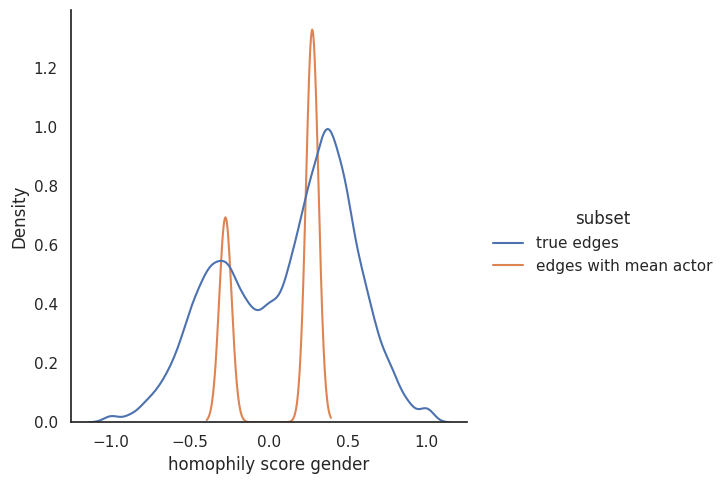

In [38]:
#| echo: false
df_visu_compare= pd.DataFrame({"homophily score gender":gender_homophily['mean']})
df_visu_compare= pd.concat([df_visu_compare, pd.DataFrame({"homophily score gender":df_actor_with_gender['homophily_gender_mean_actor'][0:int(len(df_actor_with_gender)/4)]})])
range_idx = [len(gender_homophily),int(len(df_actor_with_gender)/4)]
names = ['true edges','edges with mean actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare['subset']= idx
df_visu_compare= df_visu_compare.reset_index(drop=True)
sns.displot(data=df_visu_compare, x="homophily score gender", hue="subset", kind="kde")

## Randomization for comparison

In [39]:
#| echo: false
def mann_whitney_u_test(distribution_1, distribution_2):
    """
    Perform the Mann-Whitney U Test, comparing two different distributions.
    Args:
       distribution_1: List. 
       distribution_2: List.
    Outputs:
        u_statistic: Float. U statisitic for the test.
        p_value: Float.
    """
    u_statistic, p_value = stats.mannwhitneyu(distribution_1, distribution_2)
    return u_statistic, p_value

In [40]:
#| echo: false
df_edges_random = df_edges.copy()
df_edges_random['actor2_fbid']= sample(list(df_edges['actor2_fbid']),len(df_edges))
df_edges_merged_random= df_edges_random.merge(df_actors_reduced, on='actor1_fbid').merge(df_actors_reduced.rename(columns={"actor1_fbid": "actor2_fbid"}), on='actor2_fbid')

In [41]:
#| echo: false
df_edges_gender_rdm=df_edges_merged_random.dropna(subset=['actor_gender_x'])
df_edges_gender_rdm=df_edges_gender_rdm.dropna(subset=['actor_gender_y'])

df_edges_nat_rdm=df_edges_merged_random.dropna(subset=['actor_nationality_x'])
df_edges_nat_rdm=df_edges_nat_rdm.dropna(subset=['actor_nationality_y'])

df_edges_birth_rdm=df_edges_merged_random.dropna(subset=['year_of_birth_x'])
df_edges_birth_rdm=df_edges_birth_rdm.dropna(subset=['year_of_birth_y'])
df_edges_birth_rdm= df_edges_birth_rdm[df_edges_birth_rdm['year_of_birth_x'] < 2022]
df_edges_birth_rdm= df_edges_birth_rdm[df_edges_birth_rdm['year_of_birth_y'] < 2022]
df_edges_birth_rdm=df_edges_birth_rdm[df_edges_birth_rdm['year_of_birth_x']>1800]
df_edges_birth_rdm=df_edges_birth_rdm[df_edges_birth_rdm['year_of_birth_y']>1800]
std_yob = df_edges_birth_rdm.apply(lambda x : abs(x.year_of_birth_x-x.year_of_birth_y),axis=1).std()

edges_height_rdm=df_edges_merged_random.dropna(subset=['actor_height_x'])
edges_height_rdm= edges_height_rdm.dropna(subset=['actor_height_y'])
edges_height_rdm=edges_height_rdm[edges_height_rdm['actor_height_x']<3]
edges_height_rdm=edges_height_rdm[edges_height_rdm['actor_height_y']<3]
std_height = edges_height_rdm.drop_duplicates(subset= 'actor1_fbid').apply(lambda x : abs(x.actor_height_x),axis=1).std()

edges_nbr_movies_rdm=df_edges_merged_random.dropna(subset=['number_of_movies_x'])
edges_nbr_movies_rdm= edges_nbr_movies_rdm.dropna(subset=['number_of_movies_y'])
std_nbr_movies = edges_nbr_movies_rdm.drop_duplicates(subset= 'actor1_fbid').apply(lambda x : abs(x.number_of_movies_x),axis=1).std()

In [42]:
#| echo: false
#| output: false
df_edges_gender_rdm['same_gender'] = df_edges_gender_rdm.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
gender_homophily_rdm = df_edges_gender_rdm.groupby('actor1_fbid')['same_gender'].agg(['mean'])
df_visu_compare1= pd.DataFrame({"homophily score gender":gender_homophily['mean']})
df_visu_compare1= pd.concat([df_visu_compare1, pd.DataFrame({"homophily score gender":gender_homophily_rdm['mean']})])
range_idx = [len(gender_homophily),len(gender_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare1['subset']= idx
df_visu_compare1= df_visu_compare1.reset_index(drop=True)

In [43]:
#| echo: false
mann_whitney_u_test(list(gender_homophily['mean']), list(gender_homophily_rdm['mean']))

(1347103748.0, 3.877687697155545e-34)

In [44]:
#| echo: false
from scipy.stats import ttest_ind
stat, p_value = ttest_ind(gender_homophily,gender_homophily_rdm)
p_value

array([6.38037866e-28])

In [45]:
#| echo: false
#| output: false
df_edges_nat_rdm['same_nat'] = df_edges_nat_rdm.apply(lambda x: 1 if (x.actor_nationality_x == x.actor_nationality_y) else (-1), axis= 1)
nat_homophily_rdm = df_edges_nat_rdm.groupby('actor1_fbid')['same_nat'].agg(['mean'])
df_visu_compare2= pd.DataFrame({"homophily score gender":country_homophily['mean']})
df_visu_compare2= pd.concat([df_visu_compare2, pd.DataFrame({"homophily score gender":gender_homophily_rdm['mean']})])
range_idx = [len(country_homophily),len(gender_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare2['subset']= idx
df_visu_compare2= df_visu_compare2.reset_index(drop=True)

In [46]:
#| echo: false
mann_whitney_u_test(list(country_homophily['mean']), list(gender_homophily_rdm['mean']))

(1352574341.5, 0.0)

In [47]:
#| echo: false
#| output: false
df_edges_birth_rdm['homophily_age'] = df_edges_birth_rdm.apply(lambda x: (1- 2*abs(x.year_of_birth_x-x.year_of_birth_y)/(2*std_yob)) if abs(x.year_of_birth_x-x.year_of_birth_y)/(2*std_yob) < 1 else -1, axis= 1)
age_homophily_rdm = df_edges_birth_rdm.groupby('actor1_fbid')['homophily_age'].agg(['mean'])
df_visu_compare3= pd.DataFrame({"homophily_age":age_homophily['mean']})
df_visu_compare3= pd.concat([df_visu_compare3, pd.DataFrame({"homophily_age":age_homophily_rdm['mean']})])
range_idx = [len(age_homophily),len(age_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare3['subset']= idx
df_visu_compare3= df_visu_compare3.reset_index(drop=True)

In [48]:
#| echo: false
#| output: false
df_edges_birth_rdm['homophily_age'] = df_edges_birth_rdm.apply(lambda x: (1- 2*abs(x.year_of_birth_x-x.year_of_birth_y)/(2*std_yob)) if abs(x.year_of_birth_x-x.year_of_birth_y)/(2*std_yob) < 1 else -1, axis= 1)
age_homophily_rdm = df_edges_birth_rdm.groupby('actor1_fbid')['homophily_age'].agg(['mean'])
df_visu_compare4= pd.DataFrame({"homophily_age":age_homophily['mean']})
df_visu_compare4= pd.concat([df_visu_compare4, pd.DataFrame({"homophily_age":age_homophily_rdm['mean']})])
range_idx = [len(age_homophily),len(age_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare4['subset']= idx
df_visu_compare4= df_visu_compare4.reset_index(drop=True)

In [49]:
#| echo: false
mann_whitney_u_test(list(age_homophily['mean']), list(age_homophily_rdm['mean']))

(766980273.0, 0.0)

In [50]:
#| echo: false
#| output: false
edges_height_rdm['homophily_height'] = edges_height_rdm.apply(lambda x: (1- 2*abs(x.actor_height_x-x.actor_height_y)/(2*std_height)) if abs(x.actor_height_x-x.actor_height_y)/(2*std_height) < 1 else -1 , axis= 1)
height_homophily_rdm = edges_height_rdm.groupby('actor1_fbid')['homophily_height'].agg(['mean'])
df_visu_compare4= pd.DataFrame({"homophily_height":height_homophily['mean']})
df_visu_compare4= pd.concat([df_visu_compare4, pd.DataFrame({"homophily_height":height_homophily_rdm['mean']})])
range_idx = [len(height_homophily),len(height_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare4['subset']= idx
df_visu_compare4= df_visu_compare4.reset_index(drop=True)

In [51]:
#| echo: false
mann_whitney_u_test(list(height_homophily['mean']), list(height_homophily_rdm['mean']))

(55515587.0, 9.239917151733665e-08)

In [52]:
#| echo: false
#| output: false
edges_nbr_movies_rdm['same_nbr_movies'] = edges_nbr_movies_rdm.apply(lambda x: (1- 2*abs(x.number_of_movies_x -x.number_of_movies_y)/(2*std_nbr_movies)) if abs(x.number_of_movies_x -x.number_of_movies_y)/(2*std_nbr_movies) < 1 else -1, axis= 1)
nbr_movies_homophily_rdm = edges_nbr_movies_rdm.groupby('actor1_fbid')['same_nbr_movies'].agg(['mean'])
df_visu_compare5= pd.DataFrame({"same_nbr_movies":nbr_movies_homophily['mean']})
df_visu_compare5= pd.concat([df_visu_compare5, pd.DataFrame({"same_nbr_movies":nbr_movies_homophily_rdm['mean']})])
range_idx = [len(nbr_movies_homophily),len(nbr_movies_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare5['subset']= idx
df_visu_compare5= df_visu_compare5.reset_index(drop=True)

In [53]:
#| echo: false
mann_whitney_u_test(list(nbr_movies_homophily['mean']), list(nbr_movies_homophily_rdm['mean']))

(2283960824.5, 0.0)

Text(0.5, 0.98, 'Kernel Density Function')

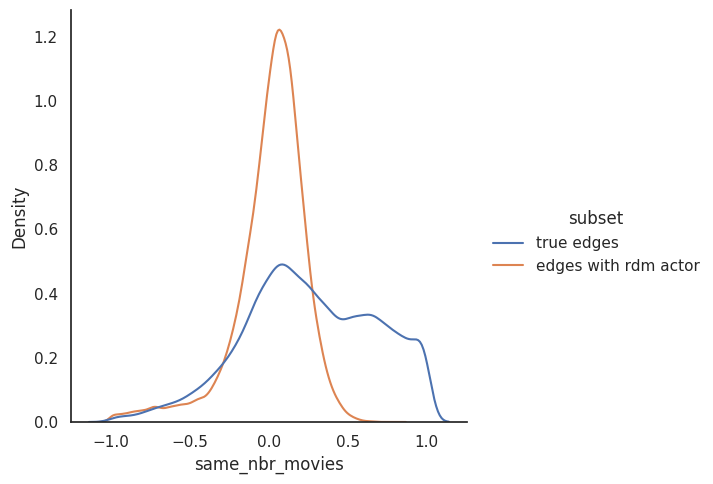

In [54]:
#| echo: false
sns.displot(data=df_visu_compare5, x='same_nbr_movies', hue="subset", kind="kde")

fig.suptitle("Kernel Density Function", fontsize=16)

Text(0.5, 0.98, 'Kernel Density Function')

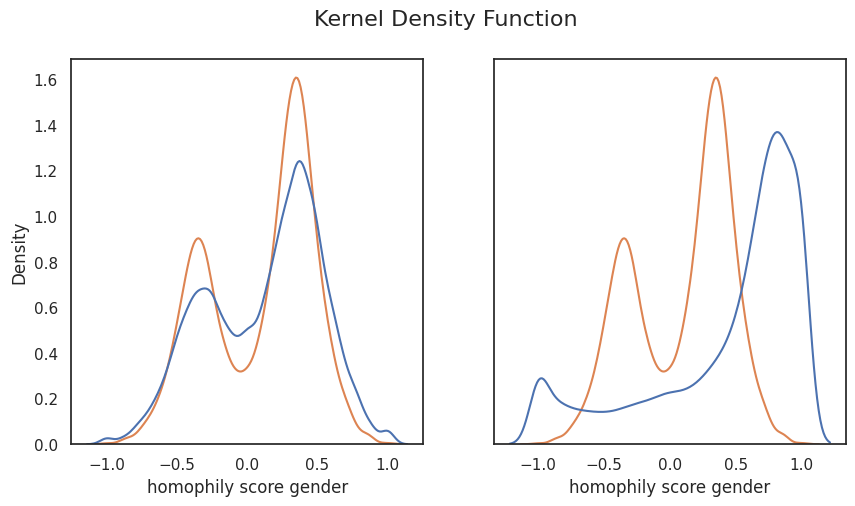

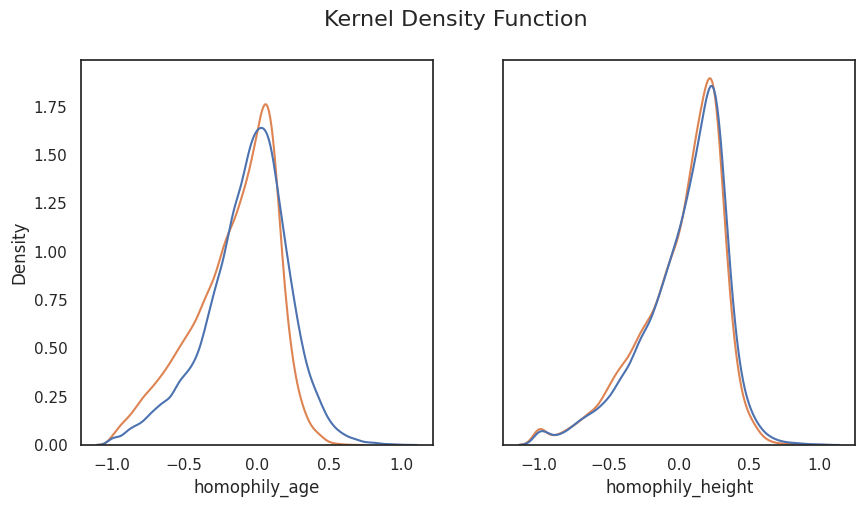

In [55]:
#| echo: false
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey= True)

sns.kdeplot(ax= axs[0],x='homophily score gender', data=df_visu_compare1, hue='subset', common_norm=False, legend= False)
sns.kdeplot(ax= axs[1],x='homophily score gender', data=df_visu_compare2, hue='subset', common_norm=False, legend= False)

fig.suptitle("Kernel Density Function", fontsize=16)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey= True)

sns.kdeplot(ax= axs[0],x='homophily_age', data=df_visu_compare3, hue='subset', common_norm=False, legend= False)
sns.kdeplot(ax = axs[1],x='homophily_height', data=df_visu_compare4, hue='subset', common_norm=False, legend= False)
fig.suptitle("Kernel Density Function", fontsize=16)


### NETWORX AND IGRAPH 

In [56]:
#| echo: false
import networkx as nx

In [57]:
#| echo: false
#| output: false
df_edges_nat.drop_duplicates(subset= 'actor1_fbid').groupby('actor_nationality_x')['actor_nationality_x'].agg(['count']).sort_values(by='count', ascending= False).head(10)

,count
actor_nationality_x,
United States of America,15534
United Kingdom,4305
India,1987
France,1647
Canada,1622
Japan,1285
Germany,860
Australia,707
Italy,575


In [58]:
#| echo: false
#| output: false
df_edges_grouped= df_edges_merged[['actor1_fbid','actor2_fbid','movie_count']]
g = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
print(g)

Graph with 57694 nodes and 1518297 edges


In [59]:
#| echo: false
#| output: false
x = df_edges_gender.drop_duplicates(subset= 'actor1_fbid')
class_attr = dict(zip(x['actor1_fbid'], 
x['actor_gender_x']))
nx.set_node_attributes(g, name = "actor_gender_x", 
values = class_attr)

In [60]:
#| echo: false
#| output: false
nx.attribute_assortativity_coefficient(g, "actor_gender_x")

0.06115305599700355

In [61]:
#| echo: false
#| output: false
df_edges_grouped= df_edges_merged[['actor1_fbid','actor2_fbid','movie_count']]
g = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
print(g)

Graph with 57694 nodes and 1518297 edges


In [62]:
#| echo: false
#| output: false
x = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')
class_attr = dict(zip(x['actor1_fbid'], 
x['actor_nationality_x']))
nx.set_node_attributes(g, name = "actor_nationality_x", 
values = class_attr)

In [63]:
#| echo: false
#| output: false
nx.attribute_assortativity_coefficient(g, "actor_nationality_x")

0.4354863403068012